<a href="https://colab.research.google.com/github/gulabpatel/Computer_Vision/blob/main/Segmentation/01_DeepLabV3_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torchvision DeepLabV3

This is a [DeepLabV3](https://arxiv.org/abs/1706.05587) colab notebook using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Initialize DeepLabV3 and download pretrained weights

In [1]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.eval().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 107MB/s]


## Segment objects on a test image

First, dowload a test image from internet:

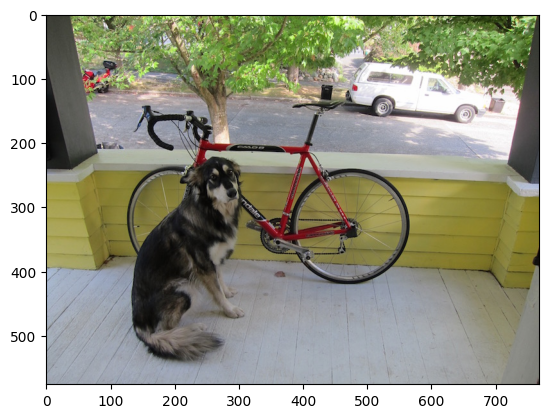

In [2]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/dog.jpg'


image_file = basename(IMAGE_URL)
!wget -q -O {image_file} {IMAGE_URL}
plt.imshow(matplotlib.image.imread(image_file))

Execute  Mask R-CNN model on that image and show the result:

In [3]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
output = model(image_tensor.unsqueeze(0))
print('executed in %.3fs' % (time.time() - t))

executed in 1.322s


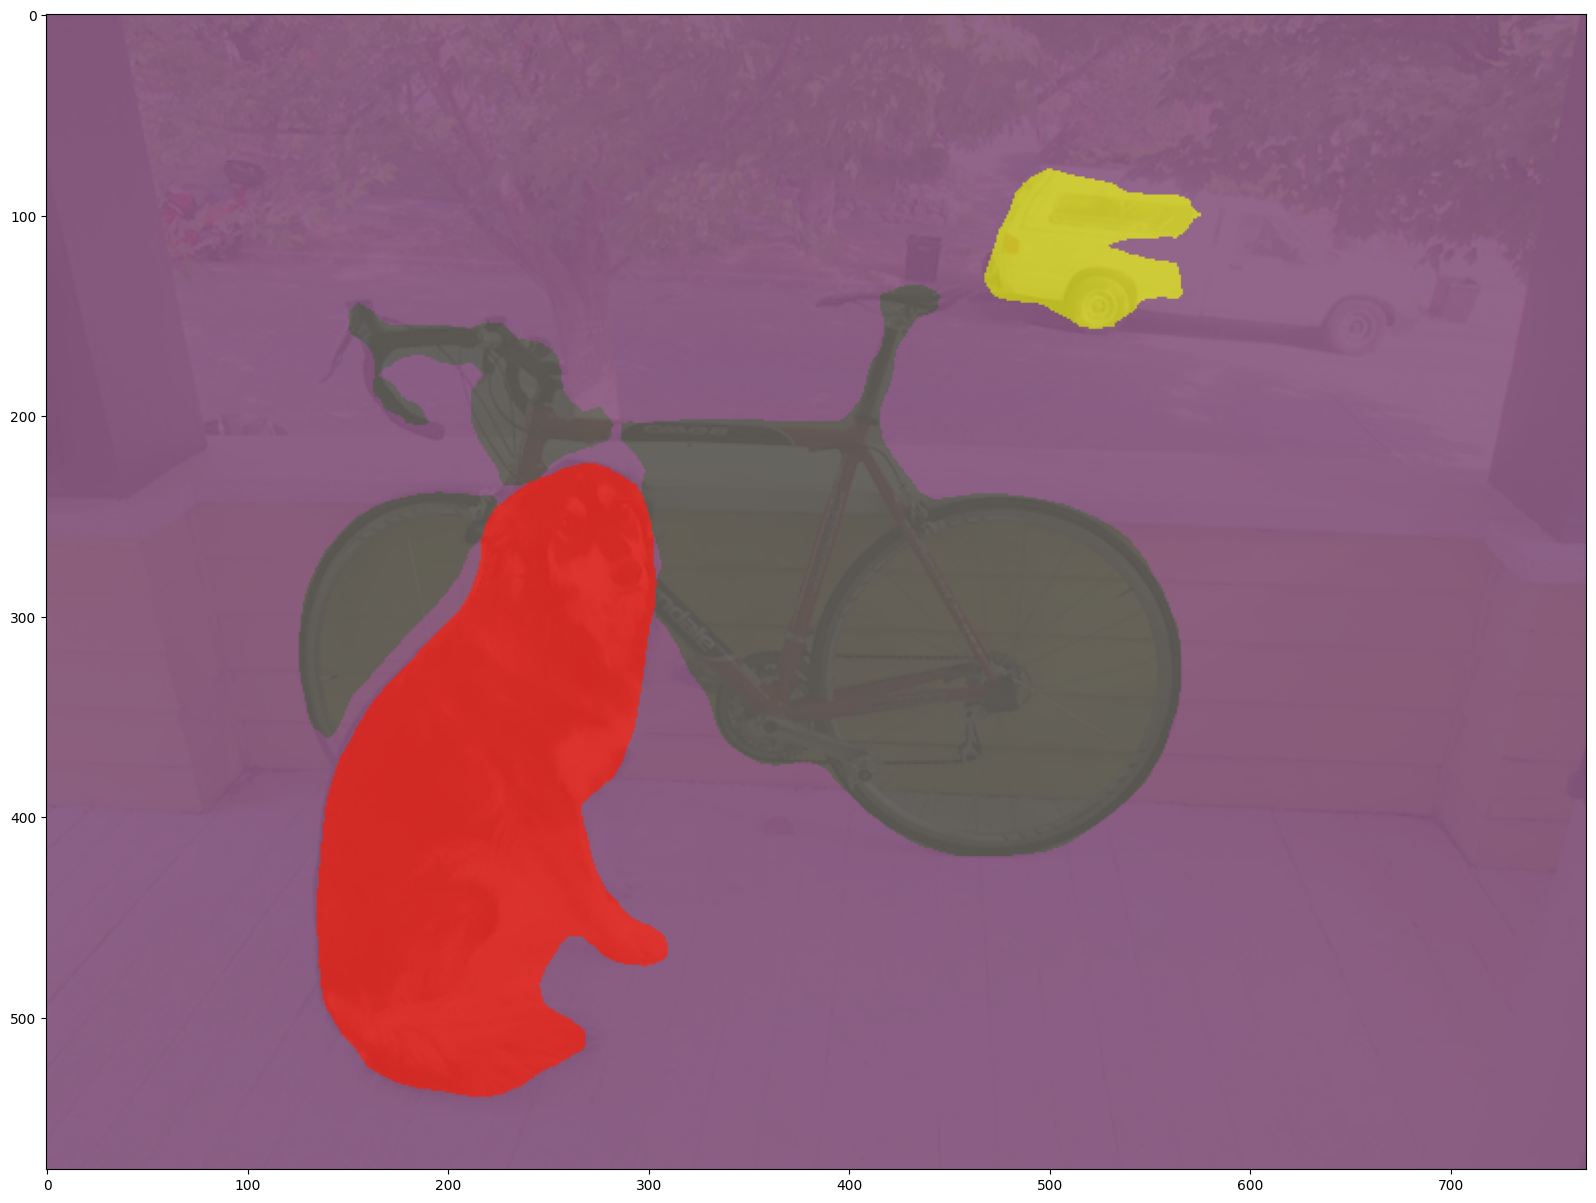

In [4]:
# visualization code copied from: https://github.com/fregu856/deeplabv3/blob/master/visualization/run_on_seq.py
#
outputs = output['out'].cpu().numpy() # (shape: (batch_size, num_classes, img_h, img_w))
pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, img_h, img_w))
pred_label_imgs = pred_label_imgs.astype(np.uint8)

label_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
def label_img_to_color(img):
    label_to_color = {
        0: [128, 64,128], 1: [244, 35,232], 2: [ 70, 70, 70], 3: [102,102,156],
        4: [190,153,153], 5: [153,153,153], 6: [250,170, 30], 7: [220,220,  0],
        8: [107,142, 35], 9: [152,251,152], 10: [ 70,130,180], 11: [220, 20, 60],
        12: [255,  0,  0], 13: [  0,  0,142], 14: [  0,  0, 70], 15: [  0, 60,100],
        16: [  0, 80,100], 17: [  0,  0,230], 18: [119, 11, 32], 19: [81,  0, 81]
        }

    img_height, img_width = img.shape
    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]
            img_color[row, col] = np.array(label_to_color[label])

    return img_color


i = 0
pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
img = image_tensor #imgs[i] # (shape: (3, img_h, img_w))

img = img.data.cpu().numpy()
img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
img = img*np.array([0.229, 0.224, 0.225])
img = img + np.array([0.485, 0.456, 0.406])
img = img*255.0
img = img.astype(np.uint8)

pred_label_img_color = label_img_to_color(pred_label_img)
overlayed_img = 0.35*img + 0.65*pred_label_img_color
overlayed_img = overlayed_img.astype(np.uint8)

plt.figure(figsize=(20, 15))
plt.imshow(overlayed_img)